In [37]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
import time
np.set_printoptions(precision=3,suppress=True)
max_linear_velocity = 3.0
max_angular_velocity = 1.5708
 
def getB(yaw, deltat):
    B = np.array([[np.cos(yaw)*deltat, 0],[np.sin(yaw)*deltat, 0],[0, deltat]])
    return B
 
def state_space_model(A, state_t_minus_1, B, control_input_t_minus_1):
    state_estimate_t = (A @ state_t_minus_1) + (B @ control_input_t_minus_1)
    return state_estimate_t
     
def lqr(actual_state_x, desired_state_xf, Q, R, A, B, dt):
    x_error = actual_state_x - desired_state_xf
    N = 100
    P = [None] * (N + 1)
    Qf = Q
    P[N] = Qf
    for i in range(N, 0, -1):
        P[i-1] = Q + A.T @ P[i] @ A - (A.T @ P[i] @ B) @ np.linalg.pinv(
            R + B.T @ P[i] @ B) @ (B.T @ P[i] @ A)      
    K = [None] * N
    u = [None] * N
    for i in range(N):
        K[i] = -np.linalg.pinv(R + B.T @ P[i+1] @ B) @ B.T @ P[i+1] @ A
        u[i] = K[i] @ x_error
    u_star = u[N-1]
    return u_star
 
def get_control_waypoints(waypoints,R, dt = 0.5,error_th = 1, verbose = False):
    waypoints = [np.array(i) for i in waypoints]
    trajectory = []
    controls = []
    error = []
    waypoints_reached = []
    actual_state_x = np.array([0,0,0])
    A = np.array([  [1.0,  0,   0],[  0,1.0,   0],[  0,  0, 1.0]])
    Q = np.array([[1, 0, 0],[0, 1.0, 0], [0, 0, 1.0]])    
    for desired_state_xf in waypoints:
        state_error_magnitude = 1e10
        waypoints_reached.append(actual_state_x)
        while state_error_magnitude >= error_th:
            if verbose:
                print(f'Current State = {actual_state_x}')
                print(f'Desired State = {desired_state_xf}')
            state_error = actual_state_x - desired_state_xf
            trajectory.append(actual_state_x)
            state_error_magnitude = np.linalg.norm(state_error)    
            error.append(state_error_magnitude)
            if verbose:
                print(f'State Error Magnitude = {state_error_magnitude}')
            B = getB(actual_state_x[2], dt)
            optimal_control_input = lqr(actual_state_x, 
                                        desired_state_xf, 
                                        Q, R, A, B, dt) 
            controls.append(optimal_control_input)
            if verbose: 
                print(f'Control Input = {optimal_control_input}')
            actual_state_x = state_space_model(A, actual_state_x, B, 
                                            optimal_control_input)
            if verbose:
                if state_error_magnitude < error_th:
                    print("\nGoal Has Been Reached Successfully!")
    return(trajectory,controls,waypoints_reached,error)




def get_animation(waypoints,trajectory,verbose=False,marker_txt=True):
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 10)) 
    ax = plt.axes(xlim=(0, 110), ylim=(0, 110)) 
    y = np.array(waypoints).T[1]
    z = np.array(waypoints).T[0]
    n = [i for i in range(len(waypoints))]
    if marker_txt:
        ax.scatter(z, y,color="Red")
        for i, txt in enumerate(n):
            ax.annotate(txt, (z[i], y[i]),color="Red")
    else:
        n = [i for i in range(len(waypoints)) if i%20==0]
        for i, txt in enumerate(n):
            ax.plot(z, y, "-r", label="course")
            ax.annotate(txt, (z[txt], y[txt]),color="Red") 
        plt.subplots()
        plt.plot(np.array(waypoints).T[0], np.array(waypoints).T[1], "-r", label="spline")
        plt.plot(np.array(trajectory).T[0], np.array(trajectory).T[1], "-g", label="tracking")
        plt.axis("equal")
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.legend()
    line, = ax.plot([], [],lw=2,   marker='>',markersize=6, ) 
    label = ax.text(40, 100, 'control', fontsize=12, color="Red")
    
    def init(): 
        line.set_data([], []) 
        return line, 
    xdata, ydata = [], [] 
    
    def animate(i): 
        x = trajectory[i][0]
        y = trajectory[i][1]
        xdata.append(x) 
        ydata.append(y) 
        line.set_data(xdata, ydata)
        text_ = "       CONTROL\n"+'Velocity: '+ str(np.round(controls[i][0],2))+'\nAngular-velocity: '+str(np.round(controls[i][1],2))
        label.set_text(text_)
        if verbose:
            print(i,x,y)
        return line, 
    anim = animation.FuncAnimation(fig, animate, init_func=init, 
                                  frames=len(trajectory), interval=1, blit=True,) 
    anim.save('coil.gif',writer='imagemagick')
    plt.subplots()
    plt.plot(np.arange(len(controls)), np.array(controls).T[0], "-r", label="Velocity")
    plt.xlabel("Time [s]")
    plt.ylabel("Velocity")
    plt.show()
    plt.subplots()
    plt.plot(np.arange(len(controls)), np.array(controls).T[1], "-r", label="Angular Velocity")
    plt.xlabel("Time [s]")
    plt.ylabel("angular Velocity")
    plt.show()
    

In [38]:
waypoints = [ [3,3,np.pi/2],
              [6,6,0],
              [3,10,np.pi/2],
              [10,20,0],
              [20,20,np.pi/2],
              [40,40,0],
              [20,40,0],
              [80,80,np.pi/2],
              [90,90,0],
              [100,100,np.pi/2]
            ]
R = np.array([[0.01,   0],[  0, 0.01]])
trajectory,controls,waypoints_reached,error = get_control_waypoints(waypoints,R, dt = 0.5,error_th = 1, verbose=False)
get_animation(waypoints,trajectory)

MovieWriter imagemagick unavailable; using Pillow instead.


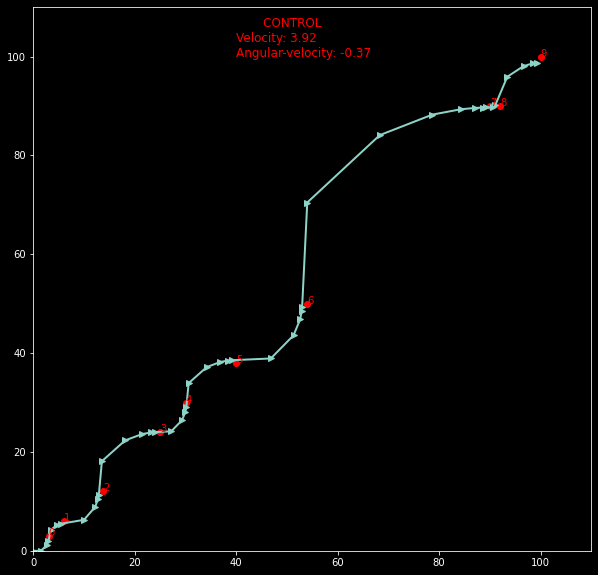

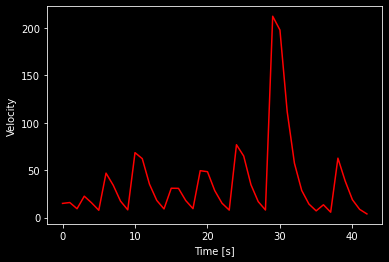

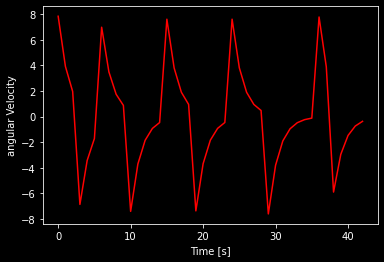

In [43]:
waypoints = [ [3,3,np.pi/2],
              [6,6,0],
              [13.75,12,np.pi/2],
              [25,24,0],
              [30,30,np.pi/2],
              [40,38,0],
              [54,50,np.pi/2],
              [90,90,0],
              [92,90,np.pi/2],
              [100,100,0]
            ]
R = np.array([[0.01,   0],[  0, 0.01]])
trajectory,controls,waypoints_reached,error = get_control_waypoints(waypoints,R,dt=0.1,error_th = 2, verbose=False)

get_animation(waypoints,trajectory)

MovieWriter imagemagick unavailable; using Pillow instead.


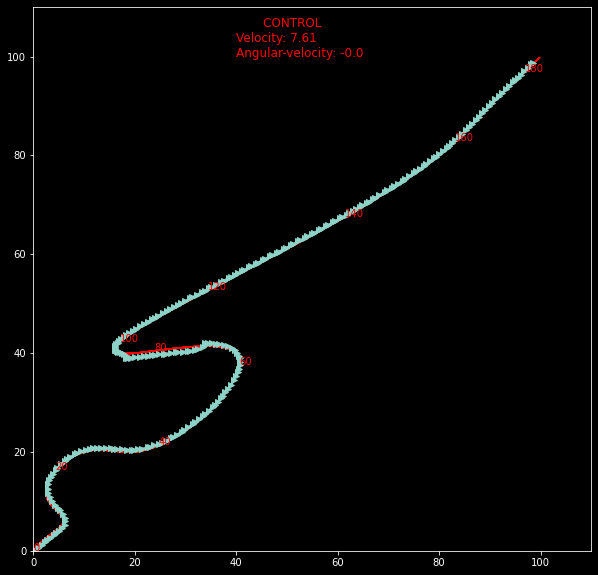

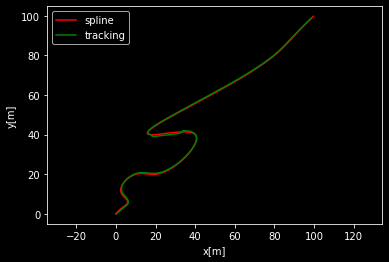

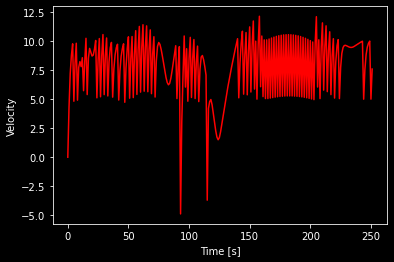

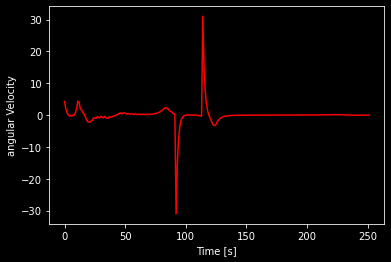

In [46]:
import cubic_spline_planner
ax = [0,3,6,3,10,20,40,20,80,90,100]
ay = [0,3,6,10,20,20,40,40,80,90,100]
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(ax, ay, ds=1)
waypoints = []
for i in range(len(cx)):
    waypoints.append([cx[i],cy[i],cyaw[i] ])
    
R = np.array([[0.01,   0],[  0, 0.01]])
trajectory,controls,waypoints_reached,error = get_control_waypoints(waypoints,R,dt=0.1,error_th = 2, verbose=False)
get_animation(waypoints,trajectory, marker_txt =False)

In [ ]:
waypoints = [ [3,3,np.pi/2],
              [6,6,0],
              [13.75,12,np.pi/2],
              [25,24,0],
              [30,30,np.pi/2],
              [40,38,0],
              [54,50,np.pi/2],
              [90,90,0],
              [92,90,np.pi/2],
              [100,100,0]
            ]

MovieWriter imagemagick unavailable; using Pillow instead.


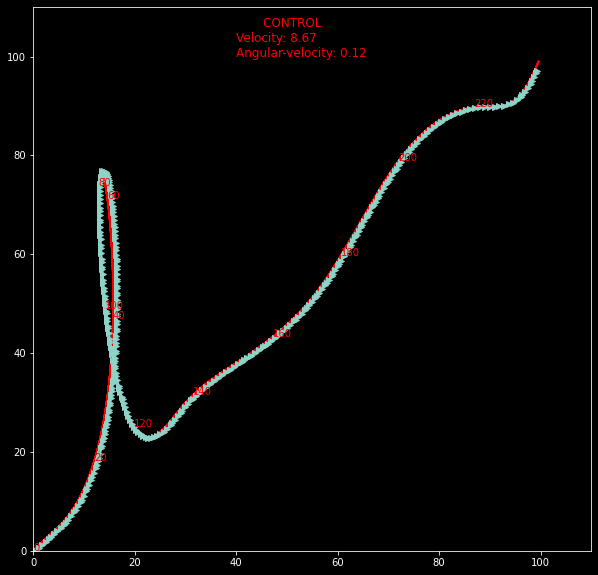

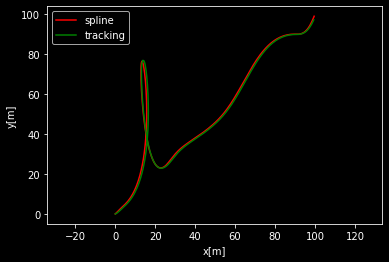

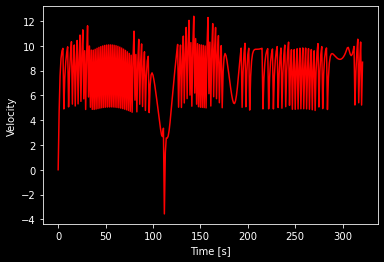

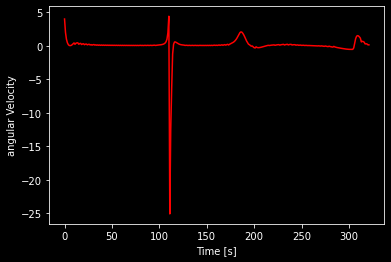

In [47]:
import cubic_spline_planner
ax = [0,3,6,13,25,30,40,54,90,92,100]
ay = [0,3,6,75,24,30,38,50,90,90,100]
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(ax, ay, ds=1)
waypoints = []
for i in range(len(cx)):
    waypoints.append([cx[i],cy[i],cyaw[i] ])
    
R = np.array([[0.01,   0],[  0, 0.01]])
trajectory,controls,waypoints_reached,error = get_control_waypoints(waypoints,R,dt=0.1,error_th = 2, verbose=False)
get_animation(waypoints,trajectory, marker_txt =False)

In [ ]:
err

In [ ]:
action